<p style="font-size:25px;font-weight:bold ">Practical 2 : Generative and Discriminative Models</p>

Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB

Useful functions

In [6]:
def compare(list1,list2):
    somme = 0
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            somme+=1
    return somme/len(list1)

def MLE_gaussian(data):
    mu = np.mean(data)
    sigma = np.var(data)
    if sigma < 1e-6:
        sigma = 1e-6
    return mu, sigma

def MLE_laplacian(data):
    mu = np.mean(data)
    b = np.mean(np.abs(data-mu))
    if b < 1e-6:
        b = 1e-6
    return mu, b
    

def simulate_distribution(data, parameter):
    
    for distribution in list(parameter.keys()):
        if distribution == "gaussian":
            mu, sigma = parameter[distribution][0], parameter[distribution][1]
            return np.exp(-(data-mu)**2/(2 * sigma)) / np.sqrt(2*np.pi*sigma**2)

        elif distribution == "bernouilli":
            p = parameter[distribution]
            return (1-p) * data + p * (1 - data)
            

<h2>Naïve Bayes Classifier</h2>

<h3>Definition of the NBC class</h3>

In [7]:
class NBC:
    """
    features_types:
            - r: real-valued
            - m: multivariate (takes value between 1 and K) ##To add support
            - b: binary (takes value in {0,1})
    
    
    
    """

    def __init__(self, features_types, num_classes):
        self.features_types = features_types
        self.num_classes = num_classes
        self.parameters = [[[] for j in range(len(features_types))] for i in range(num_classes)]
        self.pi = np.zeros(num_classes)
        self.dictionary_categories = None
    def reset(self):
        self.parameters = [[[] for j in range(len(features_types))] for i in range(num_classes)]
        self.pi = np.zeros(num_classes)
        
    def fit(self, x_train, y_train):
        
        x_train = pd.DataFrame(x_train)
        y_train = pd.DataFrame(y_train)
        x_train = pd.concat([x_train, y_train], axis =1, ignore_index  = True)
        
        """
        ##turn categories to 0,1, ...K-1
        multinomial_features = []
        for j, features_types in enumerate(self.features_types):
            categories = x_train[x_train.columns[j]].unique()
            categories_index = [i for i in range(len(categories))]
            dictionary_categories = {categories[i]:categories_index[i] for i in range(len(categories))}
            
            multinomial_features.append(categories)
            x_train[x_train.columns[j]] = x_train[x_train.columns[j]].map(dictionary_categories)
            
        self.dictionary_categories = dictionary_categories
        """
        
        for c in range(self.num_classes):
        ##fits parameter from feature j
            x_train_c = x_train.loc[x_train[x_train.columns[-1]] == c]
            self.pi[c] = len(x_train_c) / len(x_train)
            
            category_idx = 0
            
            for j, feature in enumerate(self.features_types):
                x_train_j_c = x_train_c[x_train_c.columns[j]]
            ##fits parameter from feature j
                if feature == "r":
                    ##there is two options: gaussian or laplace distribution.
                    mu_j_c, sigma_j_c = MLE_gaussian(x_train_j_c)

                    mu_j_c, b_j_c = MLE_laplacian(x_train_j_c)
                    
                    self.parameters[c][j] = {"gaussian": [mu_j_c, sigma_j_c],
                                             "laplacian": [mu_j_c, b_j_c]}
                    
                if feature == "b":
                    p_j_c = ((1-np.mean(x_train_j_c) ) * N + 1) / (N+2) ##Additive smoothing
                    self.parameters[c][j] = {"bernouilli": p_j_c}
                if feature == "m":
                    ##TODO: implement
                    print("not implemented yet")
                     
    
    
    def predict(self, x_test):
        """predicts y_test"""
        x_test = pd.DataFrame(x_test)
        #for j in range(len(x_test)):
        #    x_test[x_test.columns[j]] = x_test[x_test.columns[j]].map(self.dictionary_categories)

        best_c = -1 * np.ones(len(x_test), dtype=np.int32)
        best_log_p_y_c = - np.infty * np.ones(len(x_test))
        for c in range(self.num_classes):
            log_p_y_c = np.log(self.pi[c])
            parameters_c = self.parameters[c]
            for d in range(len(parameters_c)):
                x_test_d =  x_test[d].values
                log_p_y_c += np.log(simulate_distribution(x_test_d, parameters_c[d]))
            for i in range(len(x_test)):
                if log_p_y_c[i] > best_log_p_y_c[i]:
                    best_log_p_y_c[i] = log_p_y_c[i]
                    best_c[i] = c
        return best_c
            

<h2>Logistic Regression</h2>

<h3>Handin 1: In the lectures, we only formulated the negative log-likelihood for logistic regression
without adding any regularization term. As per the formulation used in the lectures, if you
wanted to add $w^Tw$ as a regularization to the negative log-likelihood of observing the data,
and set $\lambda = 0.1$, what value of C would you set in the sklearn implementation?</h3>

C is the inverse of the regularization. We then have to specify C = 5

<h2>Comparing NBC and LR</h2>

<h3>Iris Dataset</h3>

Load data

In [17]:
from sklearn.datasets import load_iris
iris = load_iris()
X_train, y_train = iris['data'], iris['target']


Experiments

In [18]:
features_types = ["r", "r", "r", "r"]
num_classes = 3

number_trials = 1000 ##we will average classification error
classification_error_NBC = [0 for i in range(10)]
classification_error_lR = [0 for i in range(10)]
classification_error_NBC_sklearn = [0 for i in range(10)]

for trial in range(number_trials):
    N, D = X_train.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X_train[shuffler[:Ntrain]]
    ytrain = y_train[shuffler[:Ntrain]]
    Xtest = X_train[shuffler[Ntrain:]]
    ytest = y_train[shuffler[Ntrain:]]
    for k in range(1,11):
        lR = LogisticRegression(solver='newton-cg',C = 5, multi_class='multinomial') ##chanted lbdgs to newton-cg solver
        nbc = NBC(features_types, num_classes)
        nbc_sklearn = GaussianNB()
        
        lR.fit(Xtrain[:int(k * len(Xtrain) / 10)], ytrain[:int(k * len(Xtrain) / 10)])
        nbc.fit(Xtrain[:int(k * len(Xtrain) / 10)], ytrain[:int(k * len(Xtrain) / 10)])
        nbc_sklearn.fit(Xtrain[:int(k * len(Xtrain) / 10)], ytrain[:int(k * len(Xtrain) / 10)])
        ytest_hat_lr = lR.predict(Xtest)
        ytest_hat_nbc = nbc.predict(Xtest)
      
        ytest_hat_nbc_sklearn = nbc_sklearn.predict(Xtest)

        classification_error_lR[k-1]+=compare(ytest_hat_lr, ytest)/number_trials
        classification_error_NBC[k-1]+=compare(ytest_hat_nbc, ytest)/number_trials
        classification_error_NBC_sklearn[k-1]+=compare(ytest_hat_nbc_sklearn, ytest)/number_trials

Handin 2

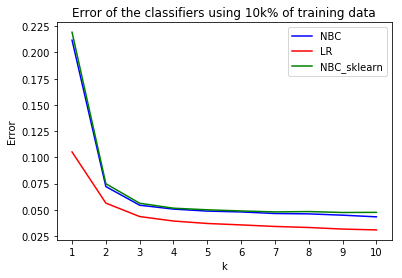

In [19]:
plt.plot([i for i in range (1,11)], classification_error_NBC,"b")
plt.plot([i for i in range (1,11)], classification_error_lR, "r")
plt.plot([i for i in range (1,11)], classification_error_NBC_sklearn, "g")

plt.xticks(np.arange(1, 11, 1))
plt.ylabel("Error")
plt.xlabel("k")
plt.title("Error of the classifiers using 10k% of training data")
plt.legend(["NBC", "LR", "NBC_sklearn"])
plt.show()

<h3>Congressional Voting Records Dataset</h3>

In [11]:
import _pickle as cp
import numpy as np
X_train, y_train = cp.load(open('voting.pickle', 'rb'))


In [14]:
features_types = ["b" for i in range(len(X_train[0]))]
num_classes = 2

number_trials = 1000 ##we will average classification error
classification_error_NBC = [0 for i in range(10)]
classification_error_lR = [0 for i in range(10)]
classification_error_NBC_sklearn = [0 for i in range(10)]


for trial in range(number_trials):
    N, D = X_train.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X_train[shuffler[:Ntrain]]
    ytrain = y_train[shuffler[:Ntrain]]
    Xtest = X_train[shuffler[Ntrain:]]
    ytest = y_train[shuffler[Ntrain:]]
    for k in range(1,11):
        lR = LogisticRegression(random_state=0, solver='lbfgs',C = 10, multi_class='multinomial')
        nbc = NBC(features_types, num_classes)
        nbc_sklearn = BernoulliNB()
        
        lR.fit(Xtrain[:int(k * len(Xtrain) / 10)], ytrain[:int(k * len(Xtrain) / 10)])
        nbc.fit(Xtrain[:int(k * len(Xtrain) / 10)], ytrain[:int(k * len(Xtrain) / 10)])
        nbc_sklearn.fit(Xtrain[:int(k * len(Xtrain) / 10)], ytrain[:int(k * len(Xtrain) / 10)])
        ytest_hat_lr = lR.predict(Xtest)
        ytest_hat_nbc = nbc.predict(Xtest)
        ytest_hat_nbc_sklearn = nbc_sklearn.predict(Xtest)
        classification_error_lR[k-1]+=compare(ytest_hat_lr, ytest)/number_trials
        classification_error_NBC[k-1]+=compare(ytest_hat_nbc, ytest)/number_trials
        classification_error_NBC_sklearn[k-1]+=compare(ytest_hat_nbc_sklearn, ytest)/number_trials

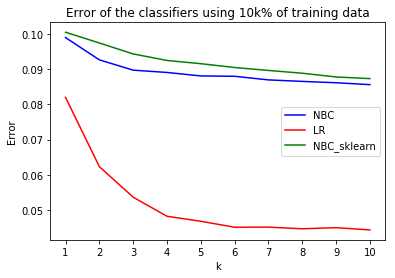

In [15]:
plt.plot([i for i in range (1,11)], classification_error_NBC,"b")
plt.plot([i for i in range (1,11)], classification_error_lR, "r")
plt.plot([i for i in range (1,11)], classification_error_NBC_sklearn, "g")


plt.xticks(np.arange(1, 11, 1))
plt.ylabel("Error")
plt.xlabel("k")
plt.title("Error of the classifiers using 10k% of training data")
plt.legend(["NBC", "LR", "NBC_sklearn"])
plt.show()